# Evoluční algoritmy - Genetické programování

Dnes se podíváme na jednoduché genetické programování. Vyzkoušíme si ho na problému symbolické regrese, kdy bude naším cílem nalézt vzoreček, který bude nejlépe odpovídat zadaným datům, a klasifikace, kdy budeme hledat rozhodovací strom pomocí genetického programování.

K tomu budeme používat knihovnu deap, kterou jsme si ukázali v průběhu minulých cvičení.

In [1]:
import random
import warnings
import operator

import numpy as np

from deap import gp
from deap import algorithms, base, creator, tools

import matplotlib.pyplot as plt
%matplotlib inline

try:
    import pydot
except ImportError:
    pydot = None
    
from IPython.display import Image, display

Nejprve si vygenerujeme data v nějakém rozumném rozsahu a k nim odpovídající labely, například pomocí funkce sinus. Pro ně pak budeme chtít najít vzoreček regrese, který jim bude nejlépe odpovídat.

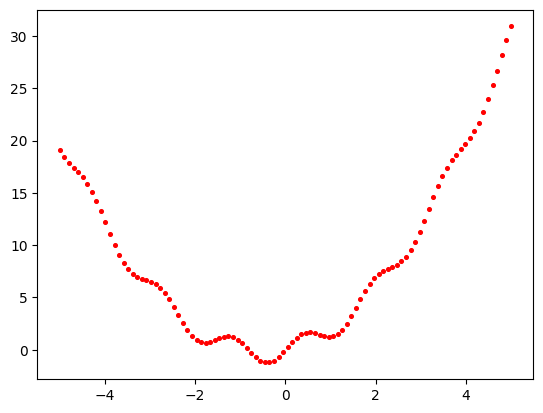

In [2]:
x_train = np.linspace(-5, 5, 100)
y_train = x_train * x_train + x_train + np.sin(4 * x_train)

plt.scatter(x_train, y_train, s=7, c="r")
plt.show()

Pro práci s genetickým algoritmem budeme potřebovat vyvořit množinu terminálů a neterminálů, se kterými bude evoluce pracovat. K tomu v knihovně deap existuje třída `gp.PrimitiveSet`, případně `gp.PrimitiveSetTyped` pro typované GP. V našem příkladu použijeme tu typovanou verzi, jelikož ale budeme používat jen jeden typ, šla by technicky vzato použít i netypovaná verze. Jako terminály si definujeme konstanty 0, 1, a 2, zbytek se dovytvoří z nich. Jako neterminály budeme potřebovat operace sčítání, násobení a sinus, a protože zbylé operace se ve vzorečku nevyskytují, nebudeme si jimi zbytečně komplikovat život.

In [3]:
# The set of nodes is named "MAIN", input is one float (x), output as well (y)
pset = gp.PrimitiveSetTyped("MAIN", [float], float)

# Rename the first (and in our case only) input argument to "x"
pset.renameArguments(ARG0="x")

# Terminals
pset.addTerminal(1.0, float)
pset.addTerminal(2.0, float)
pset.addTerminal(0.0, float)

# Non-terminals
pset.addPrimitive(np.sin, [float], float) # Here we see that we can use any custom function, not just the predefined ones.
pset.addPrimitive(operator.add, [float, float], float)
pset.addPrimitive(operator.mul, [float, float], float)

# We can add other operators, which are however not used in the original data-generating function.
# We might thusly test the GP's performance in a more "real" setting, where we do not know how
# the data were generated.
# pset.addPrimitive(operator.sub, [float, float], float)
# pset.addPrimitive(np.cos, [float], float)
# pset.addPrimitive(operator.truediv, [float, float], float)

Když máme vytvořené terminály a neterminály, můžeme si definovat jedince, fitness funkci a genetické operátory. Fitness funkce bude vycházet z [RMSE (Root Mean Squared Error)](https://en.wikipedia.org/wiki/Root-mean-square_deviation), která počítá střední hodnoty druhých mocnin rozdílů mezi predikovanou výstupní hodnotou a skutečnou výstupní hodnotou.

In [4]:
def fitness(ind, x, y):
    func = toolbox.compile(expr=ind) # We create a function defined by the individual
    vals = list(map(func, x)) # We call the function on data
    return np.sqrt(np.dot(vals-y, vals-y)), len(ind) # We compute the loss using RMSE and return it together with the size of the individual


# Defining classes for the individual
# We want to keep the individual small. This is realized by adding a multiple
# of a size of the individual to the RMSE and taking it all with a minus
creator.create("FitnessMin", base.Fitness, weights=(-1.0, -0.01))
creator.create("Individual", gp.PrimitiveTree, fitness=creator.FitnessMin)

# Setting the algorithm
toolbox = base.Toolbox()
toolbox.register("expr", gp.genHalfAndHalf, pset=pset, type_=float, min_=3, max_=10)
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.expr)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("compile", gp.compile, pset=pset)

toolbox.register("evaluate", fitness, x=x_train, y=y_train)
toolbox.register("select", tools.selTournament, tournsize=3)
toolbox.register("mate", gp.cxOnePoint)
toolbox.register("expr_mut", gp.genFull, min_=1, max_=3)
toolbox.register("mutate", gp.mutUniform, expr=toolbox.expr_mut, pset=pset) 

# Limits to the tree depth
toolbox.decorate("mate", gp.staticLimit(key=operator.attrgetter("height"), max_value=17))
toolbox.decorate("mutate", gp.staticLimit(key=operator.attrgetter("height"), max_value=17))

Nyní jsme si napsali všechny potřebné operátory a definovali jsme si populaci, tak si ještě dodefinujeme nějaké statistické metody, abychom mohli sledovat vývoj evoluce, a pak můžeme náš algoritmus pro GP spustit.

In [5]:
random.seed(23)

pop = toolbox.population(n=1000)
hof = tools.HallOfFame(1)

stats_fit = tools.Statistics(lambda ind: ind.fitness.values[0])
stats_size = tools.Statistics(len)
mstats = tools.MultiStatistics(fitness=stats_fit, size=stats_size)
mstats.register("avg", np.mean)
mstats.register("std", np.std)
mstats.register("min", np.min)
mstats.register("max", np.max)

pop, log = algorithms.eaSimple(pop, toolbox, 0.5, 0.1, 100, stats=mstats, halloffame=hof, verbose=True)

   	      	                       fitness                        	                      size                     
   	      	------------------------------------------------------	-----------------------------------------------
gen	nevals	avg    	gen	max        	min    	nevals	std   	avg   	gen	max	min	nevals	std    
0  	1000  	11447.3	0  	5.22031e+06	18.2398	1000  	231725	70.024	0  	787	4  	1000  	116.339
1  	576   	213.493	1  	88323.1    	10.3164	576   	2795.64	48.143	1  	563	2  	576   	81.4343
2  	565   	103.503	2  	487.302    	7.03293	565   	32.7854	36.413	2  	536	2  	565   	57.7498
3  	581   	93.4705	3  	1772.38    	7.03293	581   	71.9669	33.795	3  	498	2  	581   	42.8066
4  	573   	103.464	4  	10739.8    	7.03293	573   	404.875	34.985	4  	500	3  	573   	40.6878
5  	534   	79.3149	5  	4309.86    	7.03293	534   	211.454	38.376	5  	199	3  	534   	40.8198
6  	546   	67.0475	6  	3714.06    	7.03293	546   	218.974	31.654	6  	180	3  	546   	31.5344
7  	537   	56.5911	7  	4670.58    	7.0

Vidíme, že výstup výše je sice krásný a dostatečně vypovídající, ale asi bychom víc ocenili nějakou vizualici. Proto si napíšeme pomocnou funkci na zobrazení vytvořeného stromu. To uděláme pomocí knihovny *pydot*, která slouží právě ke zobrazování grafů. (K tomu ale případně potřebujeme nainstalovat i [Graphviz](https://www.graphviz.org/), který je na pozadí knihovnou *pydot* využíván, kdybyste si to chtěli vyzkoušet sami. Nezapomeňte případně přidat cestu ke Graphviz i do proměnné prostředí *PATH*, aby to byl *pydot* schopen za běhu najít a použít.)

In [6]:
# Representation of an individual as a tree
def plot_tree(tree):
    nodes, edges, labels = gp.graph(tree)
    nodesDot = list(map(lambda x: pydot.Node(x, label=str(labels.get(x))),nodes))

    g = pydot.Dot(graph_type="graph")
    for node in nodesDot:
        g.add_node(node)
    for f, t in edges:
        edge = pydot.Edge(nodesDot[f], nodesDot[t])
        g.add_edge(edge)

    return g.create_png()

Podívejme se tedy na reprezentaci nejlepšího nalezeného jedince:

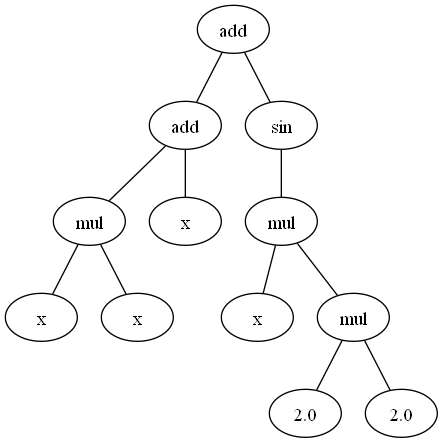

In [7]:
if pydot is None:
    warnings.warn("This display is not available due to a missing optional dependency (pydot).")
    
else:
    # Representation of the best found individual
    display(Image(plot_tree(hof[0])))

Ještě si necháme vykreslit graf, abychom se mohli podívat, jak vypadá naše naučená funkce vzhledem k datům.

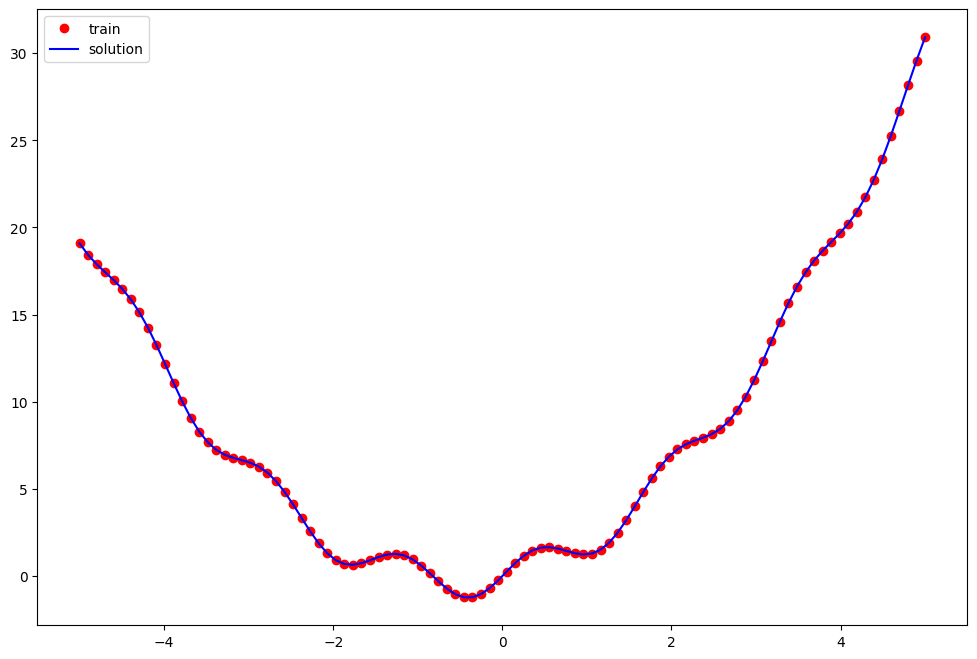

In [8]:
sol = gp.compile(hof[0], pset)

y = list(map(sol, x_train))
plt.figure(figsize=(12, 8))
plt.plot(x_train, y_train, "ro", label="train")
plt.plot(x_train, y, "b",label="solution")
plt.legend()
plt.show()

## Úkol na cvičení

Zkuste pomocí genetického programování řešit problém klasifikace, např. pro dataset Iris, se kterým jsme pracovali na prvním cvičení. Pokuste se vytvořit genetický program, který vám najde rozhodovací strom rozdělující naše kosatce do jednotlivých druhů na základě jejich čtyř parametrů. Promyslete si, jak definovat množinu primitiv a fitness. Následně je naimplementujte a pusťte genetické programování. Pokud si nebudete jisti, jak se něco v knihovně deap dělá, můžete prozkoumat [její dokumentaci](https://deap.readthedocs.io/en/master/), nebo se zeptat chatbota, který ji snad prozkoumá za vás.

Níže je načtení a preprocessing datasetu, jeho rozdělení na trénovací a testovací množinu, spuštění evolučního algoritmu a náčrt vyhodnocení výsledků. Na vás je doplnit prázdná místa (označená "TODO") - můžete si to ale samozřejmě udělat i celé zcela po svém.

In [70]:
import pandas as pd
from sklearn import metrics
import pylab as pl

iris = pd.read_csv("iris.csv")

iris.head()

,sepal.length,sepal.width,petal.length,petal.width,variety
0,5.1,3.5,1.4,0.2,Setosa
1,4.9,3.0,1.4,0.2,Setosa
2,4.7,3.2,1.3,0.2,Setosa
3,4.6,3.1,1.5,0.2,Setosa
4,5.0,3.6,1.4,0.2,Setosa


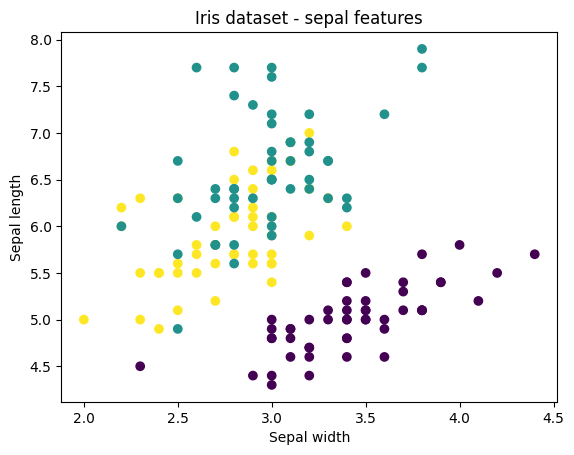

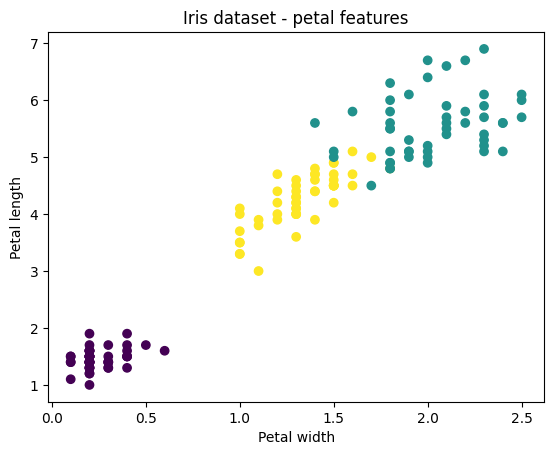

In [71]:
labels = {"Setosa": 0, "Virginica": 1, "Versicolor": 2}
iris_numerical = iris.replace({"variety": labels})

plt.scatter(iris_numerical["sepal.width"], iris_numerical["sepal.length"], c=iris_numerical["variety"])
plt.title("Iris dataset - sepal features")
plt.xlabel("Sepal width")
plt.ylabel("Sepal length") 
plt.show()

plt.scatter(iris_numerical["petal.width"], iris_numerical["petal.length"], c=iris_numerical["variety"])
plt.title("Iris dataset - petal features")
plt.xlabel("Petal width")
plt.ylabel("Petal length") 
plt.show()

In [72]:
iris_numpy = iris.to_numpy()
iris_numpy[:5]

array([[5.1, 3.5, 1.4, 0.2, 'Setosa'],
       [4.9, 3.0, 1.4, 0.2, 'Setosa'],
       [4.7, 3.2, 1.3, 0.2, 'Setosa'],
       [4.6, 3.1, 1.5, 0.2, 'Setosa'],
       [5.0, 3.6, 1.4, 0.2, 'Setosa']], dtype=object)

In [73]:
iris_x, iris_y = iris_numpy[:,:-1].astype(float), iris_numpy[:,-1].astype("U")

iris_x[:5], iris_y[:5]

(array([[5.1, 3.5, 1.4, 0.2],
        [4.9, 3. , 1.4, 0.2],
        [4.7, 3.2, 1.3, 0.2],
        [4.6, 3.1, 1.5, 0.2],
        [5. , 3.6, 1.4, 0.2]]),
 array(['Setosa', 'Setosa', 'Setosa', 'Setosa', 'Setosa'], dtype='<U10'))

In [74]:
train_to_test_ratio = 4 / 5
num_of_train_samples = int(train_to_test_ratio * len(iris_y))

permutation = np.random.permutation(len(iris_y))
train_idx = permutation[:num_of_train_samples]
test_idx = permutation[num_of_train_samples:]

x_train, x_test = iris_x[train_idx], iris_x[test_idx]
y_train, y_test = iris_y[train_idx], iris_y[test_idx]

print("Number of train samples:", num_of_train_samples, "| Number of test samples:", len(iris_y) - num_of_train_samples)

Number of train samples: 120 | Number of test samples: 30


In [ ]:
pset = ... # TODO

creator.create("Fitness", base.Fitness, weights=...) # TODO
creator.create("Individual", gp.PrimitiveTree, fitness=creator.Fitness)

toolbox = base.Toolbox()
... # TODO

In [ ]:
pop = toolbox.population(n=1000)
hof = tools.HallOfFame(1)

stats_fit = tools.Statistics(lambda ind: ind.fitness.values[0])
stats_size = tools.Statistics(len)
mstats = tools.MultiStatistics(fitness=stats_fit, size=stats_size)
mstats.register("avg", np.mean)
mstats.register("std", np.std)
mstats.register("min", np.min)
mstats.register("max", np.max)

pop, log = algorithms.eaSimple(pop, toolbox, 0.5, 0.1, 100, stats=mstats, halloffame=hof, verbose=True)

In [ ]:
sol = gp.compile(hof[0], pset)

predicted_classes = ... #TODO
accuracy = metrics.accuracy_score(y_test, predicted_classes)
print("Accuracy of the best individual:", accuracy)

In [ ]:
confusion_matrix = metrics.confusion_matrix(y_test, predicted_classes)
print("Confusion matrix of the best individual from our GP:")
print(confusion_matrix)

pl.matshow(confusion_matrix)
pl.colorbar()
pl.show()

confusion_matrix = metrics.confusion_matrix(y_test, y_test)
print("How the confusion matrix looks like for the perfect classifier:")
print(confusion_matrix)

pl.matshow(confusion_matrix)
pl.colorbar()
pl.show()